# Lecture note 3: Linear and Logistic Regression in TensorFlow

### Linear Regression

Linear은 선형, Regression은 회귀라는 의미이다. 

먼저 회귀(Regression Analysis) 분석에 대해 알아보자. 위키피디아에 따르면 회귀분석을 다음과 같이 정의하고 있다.

'관찰된 연속형 변수들에 대해 두 변수 사이의 모형을 구한뒤 적합도를 측정해 내는 분석 방법이다.'

여기서 변수가 등장하게 되는데, 회귀 분석에 사용되는 변수는 크게 두가지로 나눌 수 있다.


* 첫번째는 독립 변수(Independent variable)이다. 독립 변수는 입력값이나, 원인 등을 말하는 변수이다.

* 두번째는 종속 변수(dependent variable)이다. 종속 변수는 독립 변수들로 인해 영향을 받는 변수로, 주로 결과물을 나타낸다.


(참고 사이트 : [위키피디아, 독립변수와 종속변수](https://ko.wikipedia.org/wiki/%EB%8F%85%EB%A6%BD%EB%B3%80%EC%88%98%EC%99%80_%EC%A2%85%EC%86%8D%EB%B3%80%EC%88%98))

선형(Linear)이라는 단어는 단순하게 1차인 방정식이라고 생각하면 된다.

다시말해, 선형 회귀(linear regression)은 종속 변수 y와 한 개 이상의 독립 변수 x와의 선형 관계를 모델링하는 회귀분석 기법이다.

### Linear Regression: Predict life expectancy from birth rate

'the World Development Indicators dataset'을 가지고 Linear regression을 실습해보자. 데이터의 세부 사항은 다음과 같다.

Dataset Description
* Name: Birth rate - life expectancy in 2010
* X = birth rate. Type: float.
* Y = life expectancy. Type: foat.
* Number of datapoints: 190

### tf.data

Derek Murray의 tf.data 소개에 따르면 Placeholder와 feed_dict에 대한 좋은 점은 shuffle, batch, generate 등의 데이터 처리를 TensorFlow 외부에서 쉽게 할 수 있다는 것이다. 

단점은 이러한 메커니즘이 잠재적으로 프로그램의 속도를 저하시킬 수 있다는 점이다. 특히 단일 쓰레드를 사용하는 경우, 병목현상을 유발하기도 한다.

텐서플로에서는 데이터를 다루는 다른 방법으로 queue를 제공하기도 한다. queue를 사용하면 데이터를 loading하는 시간을 줄일 수 있지만, 사용하기 어렵고 충돌이 자주 일어나기도 한다.

따라서 최근에서는 placeholder보다 빠르고, queue보다 안전한 방법인 tf.data 모듈 사용을 권장하고 있다.

위에서 작성한 코드를 살펴보면, 각 row는 (x,y) 형태의 numpy array 로 되어 있으며, 텐서플로 모델에서 사용하기 위해 x와 y placeholder을 만들고 8번의 loop를 반복해서 사용했다. 물론 전체의 데이터를 하나의 batch로 묶어서 사용할 수도 있지만, 또다른 ops를 실행해야만 하고 전체적인 속도를 느리게 만드는 원인이 된다.

[tf.data 사용법, tensorflow 공식사이트](https://www.tensorflow.org/guide/datasets)

In [3]:
#tf.data에서는 input data를 tf형태가 아닌 다른 곳에 저장하지 않고, tf.data.Dataset object에 바로 저장하게 된다.
tf.data.Dataset.from_tensor_slices(( features , labels )))

SyntaxError: invalid syntax (<ipython-input-3-b1f6c1664841>, line 2)

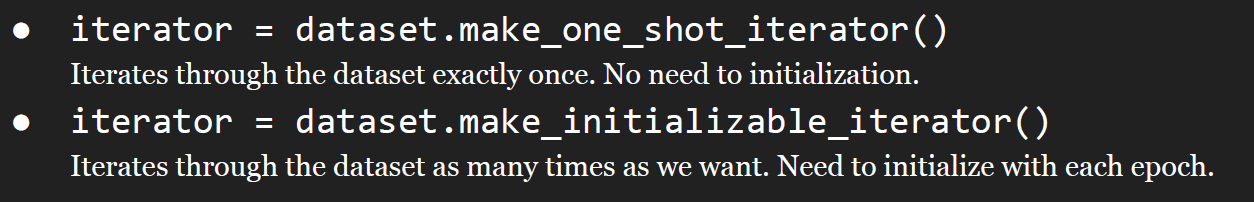

## Iterator Test

In [8]:
#make_one_shhot_iteraotr
dataset = tf.data.Dataset.range(10)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
    for i in range(10):
        value = sess.run(next_element)
        print(value)

0
1
2
3
4
5
6
7
8
9


In [12]:
#'initializable iterator' requires you to run an explicit iterator.initializer operation before using it. 
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer, feed_dict={max_value :10})
    for i in range(10):
        print(sess.run(next_element))

print('next Session')
with tf.Session() as sess:
    sess.run(iterator.initializer, feed_dict={max_value : 5})
    for i in range(5):
        print(sess.run(next_element))

0
1
2
3
4
5
6
7
8
9
next Session
0
1
2
3
4


In [17]:
#A 'reinitializable iterator' can be initialized from multiple different Dataset objects.

# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types, 
                                          training_dataset.output_shapes)
next_element = iterator.get_next()

training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
with tf.Session() as sess:
    for i in range(20):
        sess.run(training_init_op)
        print('{} start'.format(i))
        for _ in range(5):
            print(sess.run(next_element))
        
        print('valid')
        sess.run(validation_init_op)
        for _ in range(5):
            print(sess.run(next_element))

0 start
-10
2
10
-7
6
valid
0
1
2
3
4
1 start
8
-1
4
-6
5
valid
0
1
2
3
4
2 start
6
7
-6
-2
-1
valid
0
1
2
3
4
3 start
-4
4
-3
0
7
valid
0
1
2
3
4
4 start
-2
-5
-5
-5
1
valid
0
1
2
3
4
5 start
7
5
1
0
5
valid
0
1
2
3
4
6 start
-8
-4
2
-2
6
valid
0
1
2
3
4
7 start
-7
0
-8
7
9
valid
0
1
2
3
4
8 start
-2
5
3
0
6
valid
0
1
2
3
4
9 start
3
1
0
-4
10
valid
0
1
2
3
4
10 start
-2
6
1
-3
9
valid
0
1
2
3
4
11 start
-3
-6
-5
-3
9
valid
0
1
2
3
4
12 start
-4
-7
-5
-4
7
valid
0
1
2
3
4
13 start
-8
-9
8
-4
-1
valid
0
1
2
3
4
14 start
0
-3
6
-4
-6
valid
0
1
2
3
4
15 start
-10
-2
-2
6
13
valid
0
1
2
3
4
16 start
-9
3
-5
2
11
valid
0
1
2
3
4
17 start
0
-5
-7
1
2
valid
0
1
2
3
4
18 start
-7
-2
8
-2
-1
valid
0
1
2
3
4
19 start
-3
-7
2
9
-2
valid
0
1
2
3
4


## Handling data in TensorFlow

tf.data로 데이터를 불러온 다음, 추가적인 option을 설정할 수 있다.

dataset = dataset.shuffle(1000) -> 데이터를 shuffle 함수를 이용해서 섞어준다. 이 함수는 고정된 버퍼 크기로 데이터를 섞어주며, 완전히 랜덤하게 섞이기 위해서는 데이터의 수보다 큰 수를 입력해주는 것이 좋다.

dataset = dataset.repeat(100) -> 데이터가 마지막에 도달하면 반복한다.

dataset = dataset.batch(128) -> 데이터셋에서 배치 크기만큼의 데이터를 뽑는다.

참고 사이트 : [텐서플로우 데이터셋 사용 방법](https://hiseon.me/2018/04/15/tensorflow-dataset/)

## Optimizers

optimizer는 loss를 최소화하는 하나의 operation이다. 이 작업을 수행하기 위해서 Session.run의 fetch에 넣어주어야 한다. 

optimizer를 실행시키면, optimizer가 속해있는(depend on)그래프에서 연산을 수행하게 된다. 예제의 경우에는 optimizer는 loss에 종속되어 있고, loss는 input data인 X와 Y, W와 b에 종속되어 있다.

텐서보드에서 그래프를 살펴보게 되면 GradientDescentOptimizer node는 weight, bias, gradient 3개의 node에 종속되어 있는 것을 볼 수 있다.

GradientDescentOptimizer은 gradient descent 룰에 의해 업데이트 시키겠다는 의미이다.Tensorflow는 자동적으로 미분(differentiation)을 수행하고, loss를 최소화하는 방향으로 w와 b를 업데이트하게 된다.

default상태에서 optimizer는 종속되어 있는 함수의 모든 trainable variables를 training 시키게된다. 만약 train하지 않고 싶은 변수가 있다면  trainable = False 로 설정하면 된다.

그리고 특정한 variables만 optimize하도록 설정할 수 있으며, tf.stop_gradient를 사용하여 특정한 tensor의 업데이트를 막을 수 있다.
이 방법은 training 상황에서 현재의 variables를 고정하고 싶을 때 유용하게 쓸 수 있다.

* When you train a GAN (Generative Adversarial Network) where no backprop should happen through the adversarial example generation process.
* The EM algorithm where the M-step should not involve backpropagation through the output of the E-step.


Tensorflow에서는 다양한 optimizer들을 제공하고 있다. 결론적으로 말하면 AdamOptimizer를 사용하는 것이 가장 좋다.